In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib nbagg

In [15]:
def read_MC(path, file_name, n_sipms, first_sipm, tau_sipm, time_bin, event):
    #SPE_response 
    time     = np.arange(0,100000,5)
    alfa = 1.0/tau_sipm[1]
    beta = 1.0/tau_sipm[0]
    t_p = np.log(beta/alfa)/(beta-alfa)
    K = (beta)*np.exp(alfa*t_p)/(beta-alfa)
    spe_resp = K*(np.exp(-time*alfa)-np.exp(-time*beta))
    
    os.chdir(path)
    tof_wave = np.array(pd.read_hdf(file_name,key='MC/tof_waveforms'), dtype='int')
    extents  = np.array(pd.read_hdf(file_name,key='MC/extents'), dtype='int')
    
    high_limit_tof = extents[event,2]
    if event == 0:
        low_limit_tof  = 0
    else:
        low_limit_tof  = extents[event-1,2]
    
    event_tof  = tof_wave[low_limit_tof:high_limit_tof+1,:]
    event_tof[:,0] = event_tof[:,0]*-1-first_sipm
    # SiPM  |  Timebin  |  Charge   
    
    pe_table = np.zeros((np.max(event_tof[:,1])+1,n_sipms))
    
    for i in range(event_tof.shape[0]):
        pe_table[event_tof[i,1],event_tof[i,0]] = event_tof[i,2]
    
    
    conv_table = np.zeros((np.max(event_tof[:,1])+1 + spe_resp.shape[0]-1,n_sipms))
    
    for i in range(n_sipms):
        if np.max(pe_table[:,i])>0:
            conv_table[:,i] = np.convolve(pe_table[:,i],spe_resp)

    # PE Check
    #pe_T = np.sum(pe_table,axis=0)
    #pe_wave = np.array(pd.read_hdf(file_name,key='MC/waveforms'), dtype='int')
    #high_limit = extents[event,1]
    #if event == 0:
    #    low_limit  = 0
    #else:
    #    low_limit  = extents[event-1,1]
    #event_pe  = pe_wave[low_limit:high_limit+1,:]
    #event_pe[:,0] = event_pe[:,0]-first_sipm
    #pe_table_check = np.zeros((1,n_sipms))
    
    #for i in range(event_pe.shape[0]):
    #    pe_table_check[0,event_pe[i,0]] += event_pe[i,2]
    
    #print("TOF_pe   = %d" % pe_T[1443])
    #print("CHECK_pe = %d" % pe_table_check[0,1443])            
            
    
    return conv_table,pe_table,spe_resp
    

In [16]:
tof,pe_table,spe_resp = read_MC("/mnt/715c6d30-57c4-4aed-a982-551291d8f848/NEUTRINOS/","full_ring_iradius165mm_z140mm_depth3cm_pitch7mm.000.pet.h5",3500,1000,[250,15000],5,0)

<IPython.core.display.Javascript object>


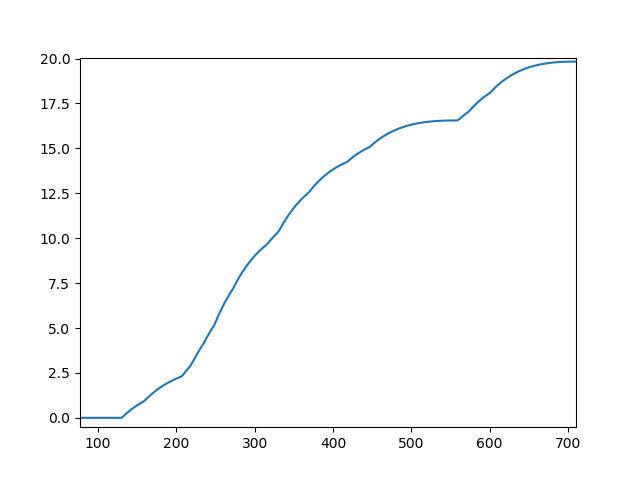

In [17]:
fig = plt.figure()
plt.plot(tof[:,1443])
plt.show()

<IPython.core.display.Javascript object>


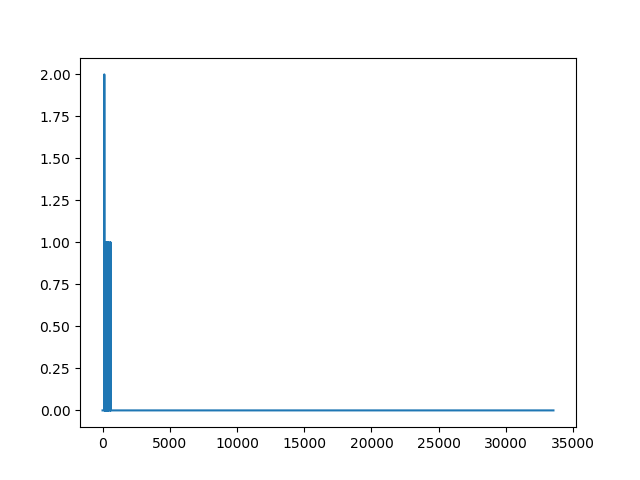

In [18]:
fig2 = plt.figure()
plt.plot(pe_table[:,1443])
plt.show()